$
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
$

# Logistic Regression (Workbook)

### ITCS 4156
### Minwoo "Jake" Lee

# Goal

The goal of this activity is to implement the logistic regression and apply it to [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) that we used last week. In addition we will look at how to analyze our predictions with a confusion matrix, a popular method for quantifying and visualizing classification predictions. Follow the TODO titles and comments to finish the activity!

# Agenda

* Iris Data: Loading and Partitioning
    * Data Partitioning
* Applying Logistic Regression
    * Converting to Indicator Variables
    * Logistic Regression Training
* Applying New Metrics
    * Confusion Matrix
    * Precision, Recall, and F1-score

In [1]:
from copy import deepcopy as copy
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Iris Data: Loading and Partitioning
Just like last week we will load the iris data via Scikit-learn. However, this week we will skip the detailed break down of the data loading and visualization. If you want to review the iris data loading process or the iris visualizations see last weeks lab on linear classification.

As we did last week we import the iris data via sklearn.To do so we call the `load_iris()` function and store the `sklearn.utils.Bunch` output instance inside the varaible `iris`. We'll also go ahead and store the iris data into variables so we don't have to keep typing `iris.data` and `iris.target` every time we need to access the data.

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
T = iris.target

## Data Partitioning

The below code is the `partition()` function we used last week. Recall, that the `partition()` function takes as input the following Numpy arrays `X` and `T`. The output of  `partition()` is a list of data and targets where `Xs` holds our training and testing data partitions and `Ts` holds our training and testing target partitions.

In [3]:
# now partition the data 

""" partitioning data

    parameters
    -----------
    X        numpy array
             input data to partition
    T        numpy array
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
    return
    -------
    
    Xs       list of numpy arrays
    
    Ts       list of numpy arrays
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Store the number of data samples 
    N = X.shape[0]

    # change the 1d array to 2d if need
    if len(T.shape) == 1:
        T = T.reshape((N,1))
    
    # Shuffle the data indices 
    idxs = np.random.permutation(N)
        
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
        nrows = int(round(N * r)) 
        
        # print (i, nrows)
        # If we are on the last ratio simply use the remaining data samples
        if k == len(ratio)-1:
            Xs.append(X[idxs[i:], :])
            Ts.append(T[idxs[i:], :])
        else:
            Xs.append(X[idxs[i:i+nrows], :])
            Ts.append(T[idxs[i:i+nrows], :])
        
        i += nrows
    
    return Xs, Ts

### TODO: 
Complete the `partition_data()` function below which will partition data into `Xtrain`, `Xtest`, `Ttrain`, and `Ttest` when called.

1. Split the `data` output from the `partition()` function into `Xtrain`, and `Xtest`
2. Split the `targets` output from the `partition()` function into `Ttrain`, and `Ttest`

In [4]:
def partition_data():
    """Partition data into train and test splits."""
    global Xtrain, Xtest, Ttrain, Ttest
    data, targets = partition(copy(X), copy(T))
    # TODO: Fill in the right had side of the assignments below
    Xtrain, Xtest = data
    # TODO: Fill in the right had side of the assignments below
    Ttrain, Ttest = targets

In [5]:
partition_data()
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (120, 4)
Train target shape: (120, 1)
Test data shape: (30, 4)
Test target shape: (30, 1)


#  Applying Logistic Regression 

Here we are, already on logistic regression - I  think this is the quickest we have ever made it to our algorithm! For this section make sure to reference the readings and lecture notes if you are getting stuck.

## Converting to Indicator Variables
Well, maybe we aren't there yet. Just like last week we need to do some preprocessing of targets so they are compatible with logistic regression. 

Remember how we adjusted our targets to `[-1, 1]` specifically for the perceptron algorithm last week? Well, we’ll be doing another adjustment of our targets, but this time we need to convert our targets to indicator variables, also called one-hot encodings. 

Recall from the lecture notes and our previous lab on linear models that converting to indicator variables means converting all our targets to a row vector of 1s and 0s. To frame this in more concrete terms we want to assign each unique target to have its own column. This means that if we have three targets (0, 1, and 2) then we have three columns, one for each target. For example, if a given data sample's indicator variable has a 1 in the first column then the rest of the columns must contain 0s. The 1 in the first column indicates to us that our target is 0!

Okay, let's recall how many unique targets our iris data has by calling the Numpy `unique()` function.

In [6]:
np.unique(Ttrain)

array([0, 1, 2])

Cool, just like last week our number of targets is 3. Remember, target 0 corresponds to setosa, target 1 corresponds to versicolor, and target 2 corresponds virginica. Let's also just take a quick look at the actual `Ttrain` targets to confirm our unique classes are all there.

In [7]:
Ttrain

array([[1],
       [2],
       [1],
       [0],
       [0],
       [2],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [2],
       [1],
       [2],
       [2],
       [0],
       [2],
       [1],
       [2],
       [2],
       [1],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [0],
       [1],
       [1],
       [1],
       [0],
       [2],
       [0],
       [2],
       [1],
       [0],
       [0],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [0],
       [2],
       [0],
       [2],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [2],
       [2],
       [2],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [2],
       [0],
       [0],
       [2],
       [1],
       [1],
    

### Indicator Variables, Numpy, and Broadcasting 
Here comes the magical part of the lab. How do we  convert our target array `Ttrain` into indicator variables? This will require a new Numpy concept called broadcasting. Broadcasting is typically an implicit concept used by Numpy to allow array arithmetic between arrays of different shapes or sizes. Below are some quotes that help convey the essence of broadcasting.

> The term broadcasting describes how numpy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes.

> In the context of deep learning, we also use some less conventional notation. We allow the addition of matrix and a vector, yielding another matrix: $C = A + b$, where $ C_{i,j} = A_{i,j} + b_j$. In other words, the vector $b$ is added to each row of the matrix. **This shorthand eliminates the need to define a matrix with $b$ copied into each row before doing the addition. This implicit copying of $b$ to many locations is called broadcasting.**


Broadcasting essentially helps save us time and memory. Going in-depth into broadcasting is out of scope for this lab, but if you wish to learn more check out the references below.

**References:**
- [Gentle Introduction to Broadcasting](https://machinelearningmastery.com/broadcasting-with-numpy-arrays)
- [Numpy Broadcasting Docs](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)

Keep in mind the following code that checks if each element meets a desired condition. In the case below our condition is that we are checking which elements in `Ttrain` equal to 1. Remember that this line of code outputs a boolean array where the true values correspond to elements in `Ttrain` that met our condition and the false values correspond to elements in `Ttrain` that failed our condition.

In [8]:
Ttrain == 1

array([[ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [

Now, we can take this aforementioned idea of checking if each element meets a desired condition and apply it to all our unique  `Ttrain` targets at once by using broadcasting. Meaning, with a single line of code we want to generate three boolean arrays, like the one above, but now instead of simply checking which elements are equal to 1, we want to check which elements are equal to 0, 1, or 2, i.e. our unique class targets.

We can do so using the below code which essentially converts ours targets into indicator variables. The below code works as if we took the boolean arrays for `Ttrain == 0`, `Ttrain == 1`, and `Ttrain == 2` and concatenated them into a single array. However, now it only takes us one line of code and works for any number of classes! Most of the complicated work here is being done behind the scenes with broadcasting.

In [9]:
Ttrain == np.unique(Ttrain)

array([[False,  True, False],
       [False, False,  True],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [Fa

The idea behind what is happening is that we have two Numpy arrays, `Ttrain` and `np.unique(Ttrain)`, being compared to create a boolean array. Recall the shape of `Ttrain` is (120, 1) and the shape of `np.unique(Ttrain)` is (3,). A note about broadcasting to keep in mind is that it can only be performed when the shape of each dimension in the arrays are equal or when one of the arrays has the dimension size of 1. Here we can see our `Ttrain` has size 1 in the 2nd dimension (column dimension). This means that `np.unique(Ttrain)` can be broadcasted with `Ttrain`. Thus, this creates our output array above which has a shape of (120, 3).

The results of this broadcasting automatically creates a boolean version of our desired indicator variables. The final step we'll need to take is converting our boolean array to 1s and 0s. We can do this by simply recasting the boolean array as an integer using Numpy's  `astype()` method. This works because the integer 1 is associated with true and the integer 0 is associated with false.

In [10]:
(Ttrain == np.unique(Ttrain)).astype(int)

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0,

Welp we did it! We somehow managed to convert our `Ttrain` targets into indicator variables through Numpy's magical broadcasting abilities.

### TODO:
Now its time for you to try. Using the idea of broadcasting presented above finish the `convert_to_indicators()` function for converting `Ttrain` and `Ttest` into indicator variables.

1. Convert `Ttrain` into an indicator variable and store the output into `Titrain`
2. Convert `Ttest` into an indicator variable and store the output into `Titest`

In [11]:
def convert_to_indicators():
    global Titrain, Titest
    # TODO (1)
    Titrain = (Ttrain == np.unique(Ttrain)).astype(int) 
    # TODO (2)
    Titest = (Ttest == np.unique(Ttest)).astype(int) 

To test if your `convert_to_indicators()` function works, run the following code. The `assert` code checks if your code produces the correct results and throws an error if it doesn't. **If you are failing the `assert` tests then something most likely went wrong in your function (check your shapes)!**

In [12]:
convert_to_indicators()
print("Train indicator shape: {}".format(Titrain.shape))
print("Test indicator shape: {}".format(Titest.shape))

Train indicator shape: (120, 3)
Test indicator shape: (30, 3)


In [13]:
assert (np.argmax(Titrain, axis=1) == Ttrain.flatten()).all()
assert (np.argmax(Titest, axis=1) == Ttest.flatten()).all()

Now we can use `Titrain` and `Titest` in our logistic regression algorithm!

## Logistic Regression Training
Now its time to implement our logistic regression algorithm. 

<img src="http://webpages.uncc.edu/mlee173/teach/itcs4156/images/class/linearlogreg.png" width=450 />

Remember, the logistic regression gradient update is as follows.
$$
\wv \leftarrow \wv + \alpha \Xm^\top \Big(  \Tm - g(\Xm)\Big).
$$

Where $w$ represents our weights, $X^T$ represents our data transposed, $T$ represents our targets, $g(X)$ represents our predictions, i.e. $X \cdot w$, and $\alpha$ represents our learning rate. 


Recall that in order to establish the probability of a given data sample belonging to one of our three flower classes, i.e. ${P(T = k | x)}$, we need to compute the softmax. Let's implement the softmax function before getting started.

### TODO

Implement the `softmax()` function and its wrapper function `g()`. Recall that the softmax is equal to the following formula.

$$
 softmax = {P(T = k | x)} = \frac{e^{z_k}}{\sum_{i=1}^K e^{z_i}}
$$

Here $z$ represents our predictions made by computing $X \cdot w$ which is calculated by the function `g()`.

1. Using Numpy's `np.exp()` function compute the numerator of the softmax function, i.e. apply the exponential function to all our predictions `z`.
2. Compute the denominator of the softmax function, i.e. apply the exponential function to all our predictions `z` and sum them.
    1. Hint: Try using Numpy's `np.sum()`
    2. Hint: If you're getting broadcasting errors make sure the numerator and denominator have the same shapes!
3. Return the softmax output calced inside `softmax()` function.
    1. Hint: Simply divide the numerator by the denominator
4. Call the `softmax()` function and pass as its parameter the predictions calculated from dotting `X` and `w`. In addition, return the output of the `softmax()` function.

In [25]:
def softmax(z):
    if not isinstance(z, np.ndarray):
        z = np.asarray(z)
    # TODO (1)
    numerator = np.exp(z)
    # TODO (2)
    if len(z.shape) == 2:
        denominator = np.sum(np.exp(z), axis=1, keepdims=True)
    else:
        denominator = np.sum(np.exp(z))
    # TODO (3)
    return numerator / denominator

# Wrapper for softmax
def g(X, w):
    # TODO (4
    return softmax(X @ w) 

Let's implement the logistic regression algorithm below. We have already created a new variable with the bias already added called `X1train`. Be sure to use `X1train` when computing the predictions and weight updates!

### TODO

1. Compute the class probabilities by calling the `g()` function which takes in the current weights `w` and all our training data with bias added `X1train`. Store the predicted class probabilities in `ys`.
2. Compute the logistic regression weight update using the predicted class probabilities `ys`, the train data with bias `X1train`, and the training indicator varaibles `Titrain`.
    1. Hint: If you are getting an error "overflow encountered in exp" simply try rerunning the cell.

In [26]:
# Convert to indicators
convert_to_indicators()

# Set shape parameters
Ntrain, D = Xtrain.shape
Ntest = Xtest.shape[0]
K = Titrain.shape[1]

# initialize the weight matrix
w = np.random.rand(D+1, K)

# iterate to update weights
niter = 1000
alpha = 0.1

# Add bias to data
X1train = np.hstack((np.ones((Ntrain, 1)), Xtrain))

likeli = []
for step in range(niter):
    # TODO (1)
    ys = g(X1train, w)
    # TODO (2)
    w += alpha * X1train.T @ (Titrain - ys)
    
# Get class probabilities for each sample in X1train
Ytrain = g(X1train, w)

# Add bias to test data
X1test = np.hstack((np.ones((Ntest,1)), Xtest))
# Get class probabilities for each sample in X1test
Ytest = g(X1test, w)

print(Ytrain)
print(Ytest)

[[1.12785879e-018 1.00000000e+000 5.33998224e-104]
 [2.25141436e-162 1.55999856e-047 1.00000000e+000]
 [5.74599181e-074 1.00000000e+000 3.40637563e-052]
 [1.00000000e+000 9.51684430e-054 0.00000000e+000]
 [1.00000000e+000 2.28749836e-092 0.00000000e+000]
 [1.24117622e-120 2.84791008e-046 1.00000000e+000]
 [1.00000000e+000 2.39701991e-078 0.00000000e+000]
 [1.84803800e-218 1.17997605e-089 1.00000000e+000]
 [1.00000000e+000 1.22058307e-066 0.00000000e+000]
 [1.00000000e+000 2.89556216e-068 0.00000000e+000]
 [6.64857481e-064 1.00000000e+000 1.92968344e-029]
 [2.41492273e-057 1.00000000e+000 3.23954549e-056]
 [1.00000000e+000 6.43635674e-080 0.00000000e+000]
 [1.09293181e-051 1.00000000e+000 1.35378011e-082]
 [1.00000000e+000 1.29882473e-050 0.00000000e+000]
 [1.00000000e+000 2.66657458e-071 0.00000000e+000]
 [1.37493555e-161 1.10341591e-063 1.00000000e+000]
 [3.93774075e-070 1.00000000e+000 8.05397296e-024]
 [1.22401654e-157 5.80705808e-073 1.00000000e+000]
 [3.81323226e-139 3.32245911e-0

After running the logistic regression algorithm we should now have the predicted class probabilities for the training data `Ytrain`, and testing data `Ytest`. The question now is how do we get our predicted labels?

The answer is quite simple! Recall, that there are three probabilities for each data sample (as seen in the above output). Logically, we want to label each data sample based on the class with the highest probability. We can do so by taking the argmax for each row in our data. The idea behind argmax is to return the column index that contains the highest probability.  Argmax works great here because our column indices are synonymous with our class targets because our targets are formatted as indicator variables!

### TODO:
Compute the argmax over our class probabilities for `Ytrain` and `Ytest`.

1. Take the argmax of the training class probabilities `Ytrian` using Numpy's `argmax()` function. Store the predicted labels in `Ltrain`.
    1. Hint: Remember to take the `argmax()` over the rows!
2. Take the argmax of the testing class probabilities `Ytest` using Numpy's `argmax()` function. Store the predicted labels in `Ltest`.
    1. Hint: Remember to take the `argmax()` over the rows!

In [92]:
# TODO (1)
Ltrain = np.argmax(Ytrain, axis=1) 
Ltrain 

array([2, 1, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 2, 1, 0,
       1, 0, 1, 2, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 1, 2, 0,
       2, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 1,
       0, 2, 2, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2,
       0, 1, 2, 1, 2, 2, 1, 0, 0, 0])

In [93]:
# TODO (2)
Ltest = np.argmax(Ytest, axis=1) 
Ltest 

array([2, 1, 2, 1, 2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0, 1,
       1, 2, 2, 2, 2, 2, 0, 1])

Awesome, now we have our predicted labels which corresponds to the classes that our logistic algorithm thought were the most likely correct for all the training and testing data samples. Let's visualize these predictions and see how they did.

Text(0.5, 1.0, 'Training results')

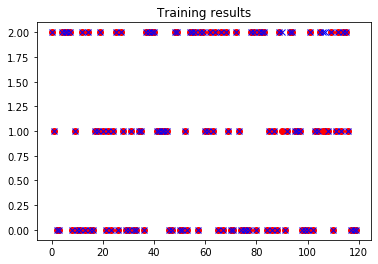

In [94]:
plt.plot(Ttrain, 'ro')
plt.plot(Ltrain, 'bx')
plt.title("Training results")

Text(0.5, 1.0, 'Test results')

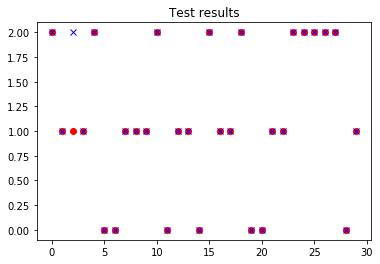

In [95]:
plt.plot(Ttest, 'ro')
plt.plot(Ltest, 'bx')
plt.title("Test results")

The below code is another way to visualize which of our `Ttest` samples we got right (True) or wrong (False). Here we are simply comparing our predicted labels `Ltest` and our target labels `Ttest`. 

In [96]:
Ltest==Ttest.flatten()

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Finally, let's quantify our algorithms preformance by computing the accuracy.

In [97]:
def print_accuracy(y, t, name):
    N = y.shape[0]
    n_correct = np.sum(y.flat == t.flat)
    n_correct_percent =  (n_correct / N) * 100
    print("{} accyracy:\t{}/{}\t{} %".format(name, n_correct, N, n_correct_percent))

In [98]:
print_accuracy(Ltrain, Ttrain, "Train")
print_accuracy(Ltest, Ttest, "Test")

Train accyracy:	117/120	97.5 %
Test accyracy:	29/30	96.66666666666667 %


As you can see our logistic regression algorithm does pretty well!

# Applying New Metrics

## Confusion Matrix 
Now it's time to visualize our results in a slightly different yet very meaningful way using a confusion matrix! A confusion matrix allows us to see the number of samples we mislabeled and which classes the samples were mislabeled as. While this may sound simplistic it is actually very powerful!

Although our confusion matrix will have a shape of (3, 3), since we have three classes, the ideas of a binary confusion matrix still apply, however things are slightly more muddled. It's important to remember that a confusion matrix comes down to a matter of perspective! Let's see what this means by looking at the rows and columns of a confusion matrix of arbitrary size. 

### Reading a NxN Confusion Matrix

Recall from the lecture notes that for a confusion matrix each row represents the predicted labels made by the model and each column represents the actual targets. This means that the main diagonal contains the number of samples we predicted correctly, i.e. our **true positives** and **true negatives**. Meanwhile, any values off the main diagonal corresponds to misclassified data samples. 

Looking row wise we can observe the **true positives** and **false positives**. Like the binary case **true posties** lie on the main diagonal. However, the rest of the row wise elements correspond to **false positives**. These being values that were predicted to be the class corresponding to the given row, but actually belong to the class corresponding to the given column. 

Likewise, looking column wise we can observe the **true negatives** and **false negatives**.Like the binary case **true negatives** lie on the main diagonal. However, the rest of the column wise elements correspond to **false negatives**. These being values that belong to the class corresponding to the given column, but were predicted to be the class corresponding to the given row. As we can see this is the reverse of the row perspective! 

### References:
- [What is true positive and true negative – confusion matrix](https://moredvikas.wordpress.com/2017/09/12/what-is-true-positive-and-true-negative-confusion-matrix/)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

### TODO:
1. Create a 3x3 confusion matrix for your test results by filling in the `confusion_matrix()` function. You can write your own or use the `confusion_matrix()` function from the [class notes](https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs4156/notebooks/notes/Note-Linear%20Classification.ipynb).

In [99]:
# TODO (1)
def confusion_matrix(Y, T):
    """
        Y    ndarray
             predicted labels
        T    ndarray
             target labels
             
        @cfm DataFrame
             confusion matrix
    """
    # TODO (1): Add code here
    if len(Y) != len(T):
        raise ValueError("Wrong prediction and target length!")
    
    classes = np.unique(T)
    n_classes = len(classes)
    
    cfm = pd.DataFrame(np.zeros((n_classes, n_classes)), index=classes, columns=classes, dtype=int)
    
    Tidx = [T == c for c in classes]
    for c in classes:
        pred_idx = Y == c
        cfm.loc[c, :] = [np.sum(np.logical_and(pred_idx, tidx)) for tidx in Tidx]
    
    return cfm

In [100]:
cfm = confusion_matrix(Ltest.flat, Ttest.flat)
cfm

,0,1,2
0,7,0,0
1,0,12,0
2,0,1,10


**Notice that `cfm` is a Pandas DataFrmae not a Nump array!**

In [103]:
type(cfm)

pandas.core.frame.DataFrame

## Precision, Recall, and F1-score 
Now that we have our confusion matrix we can use it to compute new metrics that inform us about different aspects of our models performance. Recall that we discussed precision, recall, and the F1-score in the class notes. Let's do a quick review of what these scores mean and how to compute them.

### Precision
Precision represents the accuracy when only looking at our **positive predictions**. Meaning, we want to know how many of our positive predictions were correct out of all the positive predictions made. Hence, we divide by the sum of the true positives $\mathrm{TP}$ and false positives $\mathrm{FP}$. Notice, the sum these two variables is equal the total number of positive predictions made for a given class.
$$
Precision = \mathrm{\frac{TP}{TP + FP}}
$$

### Recall
Recall represents the accuracy when only looking at the **positive targets**. This means we want to know how many positive predictions we got correct out of the actual positive targets. Hence, we divide by the sum of true positives $\mathrm{TP}$ and false negatives $\mathrm{FN}$. Notice the sum these two variables is equal the total number of targets for a given class.
$$
Recall = \mathrm{\frac{TP}{TP + FN}}
$$

### F1-score
The F1-score is used to gain a combined measure of both precision and recall. To do so we calculate the harmonic mean (the reciprocal of the arithmetic mean) of the precision and recall scores. F1-score is a good alternative to accuracy if the number false negatives and false positives are important to your problem. 
$$
F_1 = 2 \times \frac{Precision \times Recall}{Precision+Recall} = \frac{2 \times tp}{2 \times tp + fp + fn}
$$

### TODO:
Compute precision, recall, and F1-score using the elements confusion matrix `cfm`. Recall that the **rows** of the confusion matrix correspond to the *true positives* and *false positives*. Likewise, the **columns** correspond to *true negatives* and *false negatives*.

**Remember that `cfm` is a Pandas DataFrmae not a Nump array! You must index `cfm` using `cfm.iloc()`!**

1. Compute the percision score using our confusion matrix `cfm`
2. Compute the recall score using our confusion matrix `cfm`
3. Compute the F1-score score using the percision and recall

In [104]:
for i in range(3):
    t_name = iris.target_names[i]
    print("{}:".format(t_name))
    # TODO (1)
    precision = cfm.iloc[i, i] / np.sum(cfm.iloc[i, :])
    # TODO (2)
    recall = cfm.iloc[i, i] / np.sum(cfm.iloc[:, i])
    # TODO (3)
    f1 = 2 * precision * recall / (precision + recall)
    # Print scores for each class
    print("\tPrecision ({}): {:.5f}".format(t_name, precision))
    print("\tRecall ({}): {:.5f}".format(t_name, recall))
    print("\tF1 Score ({}): {:.5f}".format(t_name, f1))


setosa:
	Precision (setosa): 1.00000
	Recall (setosa): 1.00000
	F1 Score (setosa): 1.00000
versicolor:
	Precision (versicolor): 1.00000
	Recall (versicolor): 0.92308
	F1 Score (versicolor): 0.96000
virginica:
	Precision (virginica): 0.90909
	Recall (virginica): 1.00000
	F1 Score (virginica): 0.95238
